# Latent Dirichlet Allocation

In this final assignment, you will implement LDA and try it out on a corpus. Be sure to start work on this assignment early, because running your code will take some time. A full run of my implementation took about four hours. Consider running your code on smaller subcorpora during debugging.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Data loading

Try your Gibbs sampler on the corpus of 2000 movie reviews from Pang & Lee (2004), available on Classroom. The first line of the file specifies the number of documents. Then each subsequent line is one document, with the tokens separated by whitespace. I generated the file on Classroom from the original movie reviews by tokenizing them and then removing punctuation and stopwords, so you get nicer topics.

In [16]:
%%capture
! pip install pyLDAvis

In [17]:
FORCE_RETRAIN_MODEL = False
PATH_TO_TRAINED_MODEL = os.path.join('30_01_2022_00_14_40', 'model.json')
NUM_OF_ITERATIONS = 10
# -1 is default for saving only after full train
SAVE_EVERY_N_ITERATIONS = -1

SOURCE_DATA_FILENAME = 'movies-pp.txt'
SOLUTION_FILENAME = 'solution.py'

In [18]:
import os

if not os.path.isfile(SOURCE_DATA_FILENAME):
  ! wget https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Computational_Linguistics/HW6_LDA/$SOURCE_DATA_FILENAME

if not os.path.isfile(SOLUTION_FILENAME):
  ! wget https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Computational_Linguistics/HW6_LDA/$SOLUTION_FILENAME

In [19]:
from solution import DataHelper
data_helper = DataHelper(SOURCE_DATA_FILENAME)

print(data_helper.NUM_OF_DOCS, data_helper.VOCAB_SIZE, data_helper.CORPUS_SIZE)

2000 7944 542286


## Gibbs sampler

Implement a Gibbs sampler which resamples a topic for each word in the corpus according to the probability distribution in formula [5] of [Griffiths & Steyvers (2004)](https://www.pnas.org/content/101/suppl_1/5228). Initialize the topic assignments by choosing a topic uniformly at random for each token in the corpus. You can also refer to [Darling tutorial](https://u.cs.biu.ac.il/~89-680/darling-lda.pdf) for details of implementation.

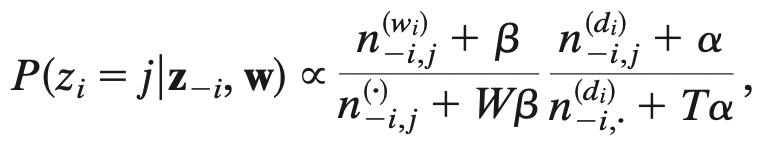

[26934, 27154, 27239, 27022, 26945, 26953, 27000, 27403, 27108, 26652, 27309, 27173, 27226, 27059, 27209, 27265, 27046, 27058, 27192, 27339]


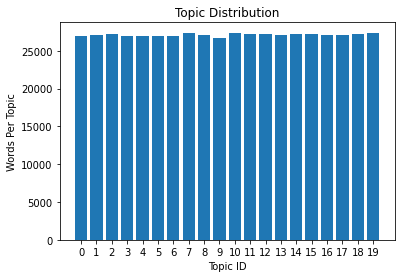

In [20]:
from solution import plot_topic_distribution

print(data_helper.topic_counter)
plot_topic_distribution(data_helper.topic_counter)

Algorithm
```
1) Run if for NUM_OF_ITERATIONS (hyperparam)
2) For each word in corpus (non-unique)
    get current topic
    decrease all respective counts:
       - general count of this topic;
       - count of this topic for specific word;
       - count of this topic in document;
    run loop over topics count K
      re-evaluate word_to_topic sampling probabilites
    choose new topic for the word based on weights obtained above
    increase all respective counts
```

Apply Gibbs sample to full corpus:

In [21]:
from solution import GibbsSampler

if FORCE_RETRAIN_MODEL:
    gibbs_sampler = GibbsSampler(data_helper)
    data_helper = gibbs_sampler.train(NUM_OF_ITERATIONS, iterations_to_save=SAVE_EVERY_N_ITERATIONS)
    path_to_trained_helper = data_helper.export_trained_helper()
else:
    data_helper = DataHelper.import_trained_helper(data_helper, PATH_TO_TRAINED_MODEL)
    data_helper.run_consistency_tests()

In [22]:
data_helper.print_top_words_for_all_topics()

Topic ID: 1
Top-10 words: ['see', 'characters', 'well', 'could', 'really', 'films', 'little', 'life', 'people', 'plot']
Topic ID: 2
Top-10 words: ['see', 'characters', 'well', 'could', 'really', 'films', 'little', 'life', 'plot', 'people']
Topic ID: 3
Top-10 words: ['characters', 'see', 'well', 'could', 'really', 'films', 'little', 'life', 'people', 'scene']
Topic ID: 4
Top-10 words: ['see', 'characters', 'well', 'could', 'really', 'films', 'little', 'life', 'plot', 'people']
Topic ID: 5
Top-10 words: ['characters', 'see', 'well', 'could', 'really', 'films', 'little', 'life', 'plot', 'people']
Topic ID: 6
Top-10 words: ['see', 'characters', 'well', 'could', 'really', 'films', 'little', 'life', 'people', 'plot']
Topic ID: 7
Top-10 words: ['see', 'characters', 'well', 'could', 'really', 'films', 'little', 'life', 'plot', 'people']
Topic ID: 8
Top-10 words: ['see', 'characters', 'well', 'could', 'really', 'films', 'little', 'life', 'plot', 'people']
Topic ID: 9
Top-10 words: ['characters'

Experiment without filtering out very common words failed, since even after 500 iterations I had almost the same topic wordlists.

Try out different numbers of topics and iterations and different values for the hyperparameters. You should get good results with 20 topics, 500 iterations over the corpus, α = 0.02, and β = 0.1. Print, for each topic, the most frequent words for that topic in the final sample, and discuss to which extent the topics actually represent thematically coherent semantic fields.

In [23]:
import pyLDAvis

movies_vis_data = data_helper.get_movies_vis_data()
pyLDAvis.display(movies_vis_data)

/users/tsimafeip/pythonProject/venv_m1/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## Extra credit

- Use Numpy to speed up the calculations;
- try your system on other corpora; 
- experiment with different strategies for initializing the topic assignments (e.g., give the same topic to all words of the same document);
- use a bit of supervised information (e.g., fix the topic assignments for specific words that you know should belong to that topic, and do not allow the sampler to change them).
